### Import libraries

In [76]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Set device and hyperparameters

In [77]:
#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set Hyperparameters
num_epochs = 20
num_classes = 50
batch_size = 64
learning_rate = 1e-4
train_split = 0.8
val_split = 0.1
torch.manual_seed(0)

### Load data with some transforms operations for augmentation

In [78]:
# define transforms for data augmentation
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Load data
# Dataset is present in BarkVN-50_mendeley folder in the same directory as this file
dataset = datasets.ImageFolder(root='BarkVN-50_mendeley', transform=trans)

### EDA
- Check for class Imbalance - Mostly all the classes are balanced
- Display some sample images

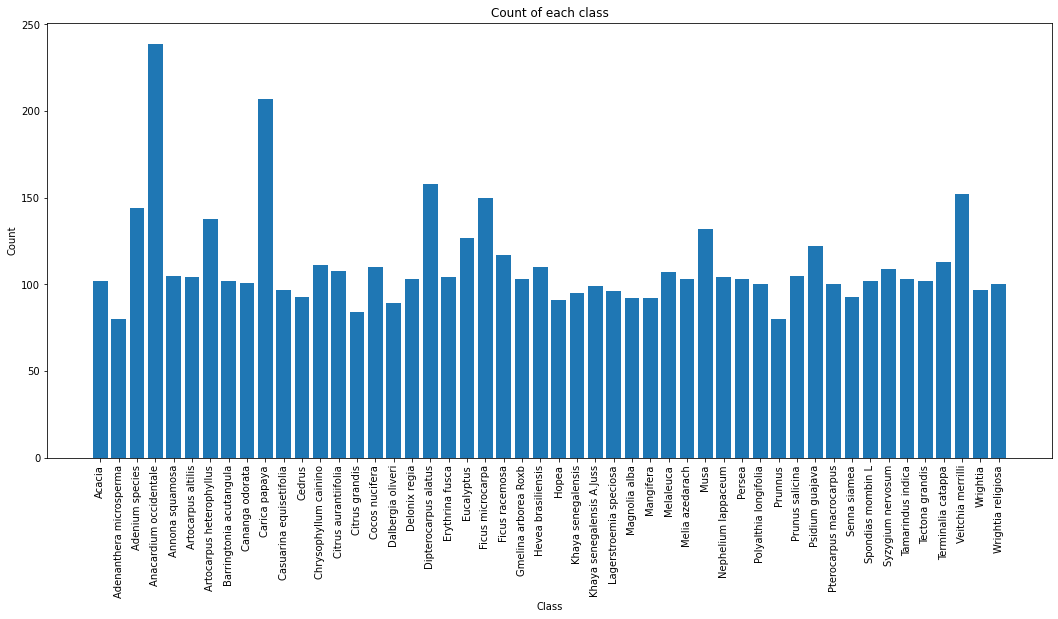

In [79]:
# visualize count of each class
classes = dataset.classes
class_count = [0] * len(classes)
for _, label in dataset:
    class_count[label] += 1
plt.figure(figsize=(18, 8))
plt.bar(classes, class_count)
plt.xticks(rotation=90)
plt.title('Count of each class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

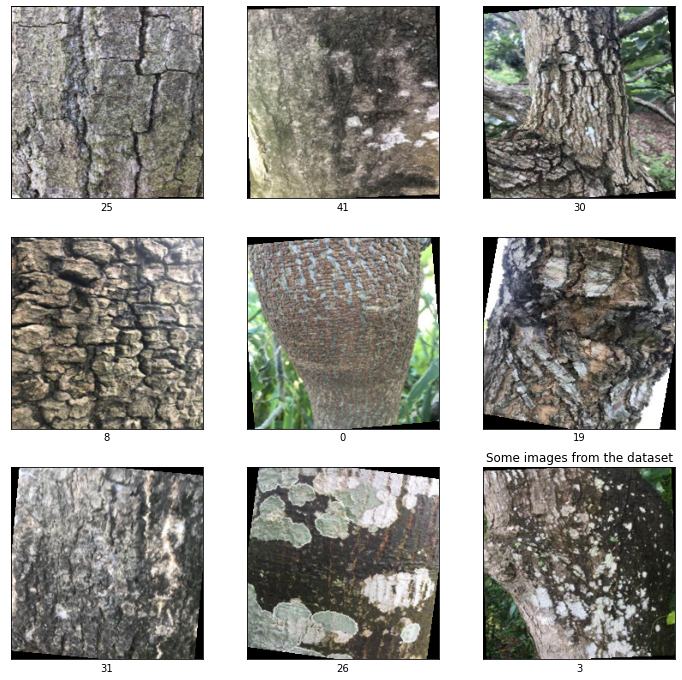

In [80]:
# plot some images to see what we are dealing with
plt.figure(figsize=(12,12))

for j,i in enumerate(np.random.randint(0, len(dataset), 9)):
    plt.subplot(3,3,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(torch.permute(dataset[i][0],(1, 2, 0)).numpy())
    plt.xlabel(dataset[i][1])

plt.title('Some images from the dataset')
plt.show()

### Split data 

- train 80%
- val 10%
- test 10%

In [81]:
#split data into train and test and validate
train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

### Load Pretrained Resnet50 model and apply transfer learning

In [82]:
# Load pretrained model
model = models.resnet50(weights=models. ResNet50_Weights.DEFAULT)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# Replace last layer for transfer learning since we have 50 classes
model.fc = nn.Sequential(
                      nn.Linear(model.fc.in_features, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.3),
                      nn.Linear(256, num_classes),                   
                      nn.LogSoftmax(dim=1))

### Train Model to update the weights modified fc layer

- Tracked validation loss to early stop


Epoch [0/20] train_Loss: 262.3450 Val_Loss: 31.8651 Validation accuracy: 19.93
Epoch [1/20] train_Loss: 227.6374 Val_Loss: 26.9852 Validation accuracy: 44.34
Epoch [2/20] train_Loss: 190.6387 Val_Loss: 22.6930 Validation accuracy: 56.73
Epoch [3/20] train_Loss: 159.5797 Val_Loss: 19.2704 Validation accuracy: 63.55
Epoch [4/20] train_Loss: 132.4221 Val_Loss: 16.2055 Validation accuracy: 73.43
Epoch [5/20] train_Loss: 112.0017 Val_Loss: 13.4823 Validation accuracy: 77.56
Epoch [6/20] train_Loss: 97.5208 Val_Loss: 11.8306 Validation accuracy: 79.17
Epoch [7/20] train_Loss: 84.8337 Val_Loss: 10.4715 Validation accuracy: 80.61
Epoch [8/20] train_Loss: 74.7358 Val_Loss: 9.6498 Validation accuracy: 83.12
Epoch [9/20] train_Loss: 67.0030 Val_Loss: 8.7143 Validation accuracy: 82.23
Epoch [10/20] train_Loss: 61.0068 Val_Loss: 8.0961 Validation accuracy: 84.02
Epoch [11/20] train_Loss: 55.5677 Val_Loss: 7.3534 Validation accuracy: 83.84
Epoch [12/20] train_Loss: 50.9840 Val_Loss: 6.7460 Validatio

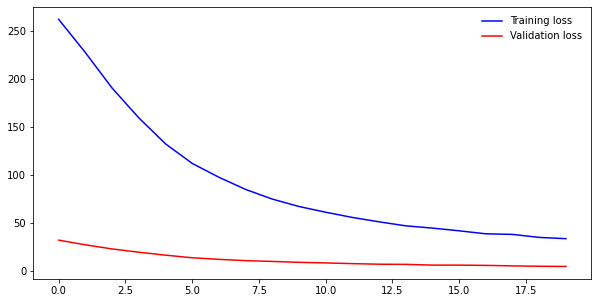

In [83]:
# Initialize model
model = model.to(device)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Traininig loop
best_val_loss = float('inf')
best_val_acc = 0
best_model = None
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    counter = 0
    train_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to device
        data = data.to(device)
        targets = targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        train_loss += loss.item()

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    train_losses.append(train_loss)



    # Display validation accuracy after every epoch
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        val_loss = 0
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            val_loss += criterion(scores, targets)
            _, predictions = scores.max(1)
            n_correct += (predictions == targets).sum()
            n_samples += predictions.size(0)
        acc = 100.0 * n_correct/n_samples
        print(f'Epoch [{epoch}/{num_epochs}] train_Loss: {train_loss:.4f} Val_Loss: {val_loss:.4f} Validation accuracy: {acc:.2f}')

        val_losses.append(val_loss.item())

    # save best model
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_val_acc = acc
        best_model = model.state_dict()
        torch.save(best_model, 'model.ckpt')
    
    # early stopping
    if val_loss.item() > best_val_loss:
        if counter >=10:
            print('Early stopping')
            break
        else:
            counter += 1

# Plot training and validation loss
plt.figure(figsize=(15,8))
t = [i for i in range(num_epochs)]
plt.plot(t, train_losses, label='Training loss', color='blue')
plt.plot(t, val_losses, label='Validation loss', color='red')
plt.xticks(t)
plt.legend(frameon=False)
plt.show()


### Load the saved model

In [84]:
# load model
model = models.resnet50(weights=models. ResNet50_Weights.DEFAULT)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# Replace last layer for transfer learning
model.fc = nn.Sequential(
                      nn.Linear(model.fc.in_features, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes),                   
                      nn.LogSoftmax(dim=1))

model.load_state_dict(torch.load('model.ckpt'))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Evaluate the model 
- Reported Confusion Matrix and Classification Report and 

Got 532 / 559 on test data with accuracy 95.17
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        20
           4       0.90      1.00      0.95         9
           5       1.00      0.92      0.96        13
           6       0.93      1.00      0.97        14
           7       0.86      0.86      0.86         7
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        10
          11       0.80      1.00      0.89         8
          12       1.00      0.92      0.96        13
          13       1.00      1.00      1.00        10
          14       1.00      0.87      0.93        15
          15       1.00      1.00      1.00        12
          16

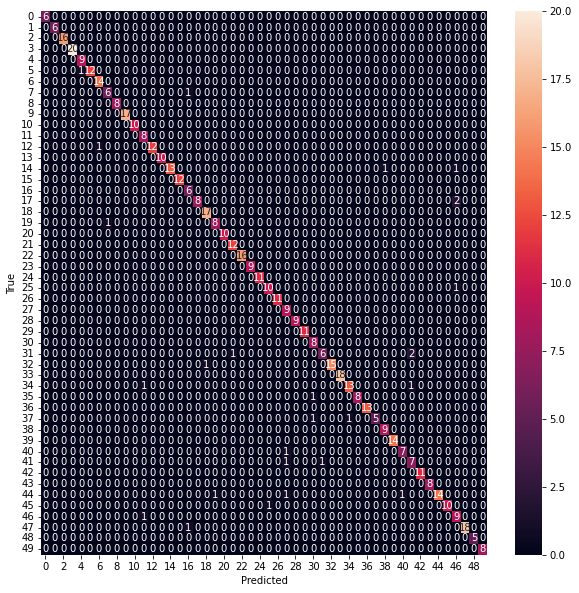

In [97]:
# Report Metrics

def evaluate_model(loader, model):
    y_pred = []
    y_true = []
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(y.cpu().numpy())
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
        print(
            f'Got {num_correct} / {num_samples} on test data with accuracy {float(num_correct)/float(num_samples)*100:.2f}'
        )

        print('Classification Report')
        print(classification_report(y_true, y_pred))


        print('Confusion Matrix')
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    model.train()


evaluate_model(test_loader, model)
